In [1]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment

/home/soom/miniconda3/envs/clode/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model and Dataset (LOL train 485 images)

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'pth/universal.pth', weights_only=True), strict=False)

file_path = Path('/home/soom/data/our485')
img_labels = sorted(os.listdir(file_path / 'low'))

def load_image(idx):
    lq_img = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
    gt_img = image_tensor(file_path / 'high' / img_labels[idx], size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device)


Try find best T values by PSNR

In [ ]:
# due to time constraints, run on python (.py) script

T_values = np.linspace(2, 5, 30)
results = []

with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        lq_img, gt_img = load_image(idx)

        high_psnr = 0.0
        best_T = 2.0
        for T in tqdm(T_values, leave=False):
            integration_time = torch.tensor([0, T]).float().cuda()
            pred = model(lq_img, integration_time, inference=True)['output'][0]
            
            _psnr = calculate_psnr(pred, gt_img).item()
            if high_psnr < _psnr:
                high_psnr = _psnr
                best_T = T
        results.append([best_T, high_psnr])

results = np.array(results)
np.save('results.npy', results)

In [3]:
results = np.load('results.npy')
results.shape

(485, 2)

Adapt $\alpha$, $\beta$, $\gamma$ so that weighted IQA score approximates score with optimal T

In [ ]:
# due to time constraints, run on python (.py) script
import scipy.optimize as opt

prompts = ('brightness', 'noisiness', 'quality')
clip_iqa = CLIPImageQualityAssessment(prompts=prompts).to(device)

scores = np.zeros((len(img_labels), 3))     # (485, 3)

with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        lq_img, gt_img = load_image(idx)

        T = results[idx][0]
        integration_time = torch.tensor([0, T]).float().cuda()
        pred = model(lq_img, integration_time, inference=True)['output'][0]
        
        score = clip_iqa(pred.unsqueeze(0))
        scores[idx] = [score[prompt].item() for prompt in prompts]

np.save('scores.npy', scores)

In [12]:
scores = np.load('scores.npy')
scores.shape

(485, 3)

In [ ]:
"""
Optimization idea1 (Deprecated). weights adjustment using iterative optimization
"""
prompts = ['brightness', 'noisiness', 'quality']
weights = [1.0, 1.0, 1.0]
clip_iqa = CLIPImageQualityAssessment(prompts=prompts).to(device)

learning_rate = 0.1
asc, desc = learning_rate * len(prompts) / (len(prompts) -1), learning_rate / (len(prompts) - 1)

def adjust_clip_weights(pred, weights):
    score = clip_iqa(pred.unsqueeze(0))
    scores = [score[prompt].item() for prompt in prompts]
    max_idx = np.argmax(scores)
    
    weights[max_idx] += asc
    weights -= desc
    
    return weights

with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        lq_img, gt_img = load_image(idx)

        T = results[idx][0]
        integration_time = torch.tensor([0, T]).float().cuda()
        pred = model(lq_img, integration_time, inference=True)['output'][0]
            
        weights = adjust_clip_weights(pred, weights)

print(weights)


In [13]:
"""
Optimization idea2. weights adjustment by minimizing variance of S (weighted sum)
"""
def variance_objective(weights):
    weights = weights / np.sum(weights)
    S = weights[0] * scores[:, 0] + weights[1] * scores[:, 1] + weights[2] * scores[:, 2]

    return np.var(S)

init_weights = np.array([1/3, 1/3, 1/3])
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1), (0, 1), (0, 1)]

result = opt.minimize(variance_objective, init_weights, bounds=bounds, constraints=constraints)
optimal_weights = result.x / np.sum(result.x)

optimal_weights

array([0.17940587, 0.65850059, 0.16209354])

Evaluate whether optimal score (weighted sum) aligns well with PSNR across varing T.

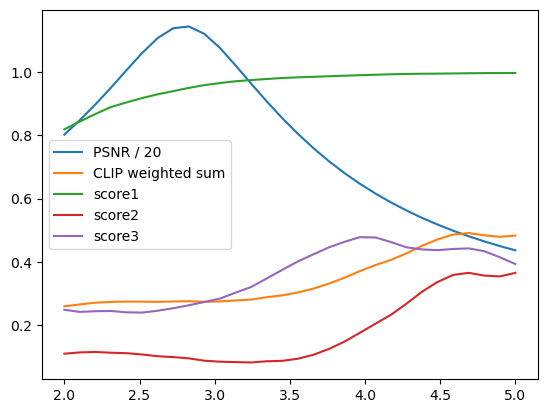

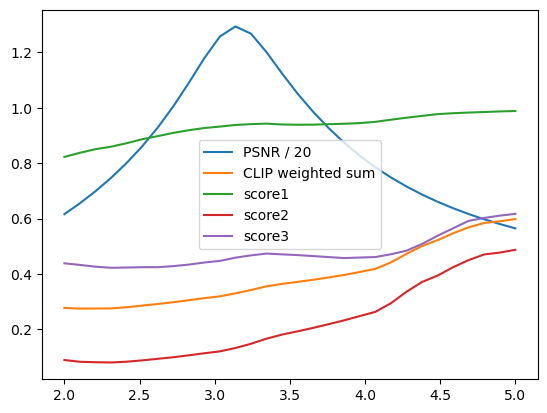

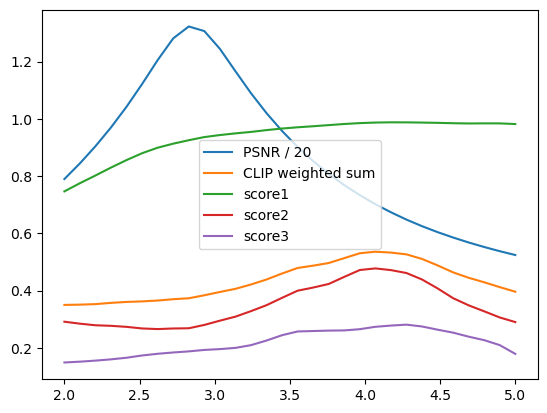

In [20]:
file_path = Path('/home/soom/data/eval15')
img_labels = sorted(os.listdir(file_path / 'low'))

def calculate_clip_score(pred):
    score = clip_iqa(pred.unsqueeze(0))
    scores = [score[prompt].item() for prompt in prompts]
    
    return np.dot(scores, optimal_weights), scores

T_values = np.linspace(2, 5, 30)

with torch.no_grad():
    for idx in range(len(img_labels[:3])):
        arr_psnr, arr_ssim, arr_clip, arr_scores = [], [], [], []
        lq_img, gt_img = load_image(idx)

        for T in tqdm(T_values, leave=False):
            integration_time = torch.tensor([0, T]).float().cuda()
            pred = model(lq_img, integration_time, inference=True)['output'][0]
            
            _psnr = calculate_psnr(pred, gt_img).item()
            # _ssim = calculate_ssim(pred, gt_img).item()
            _clip, _idv_scores = calculate_clip_score(pred)
            
            arr_psnr.append(_psnr)
            # arr_ssim.append(_ssim)
            arr_clip.append(_clip)
            arr_scores.append(_idv_scores)

        arr_psnr = np.array(arr_psnr)
        arr_scores = np.array(arr_scores)

        plt.plot(T_values, arr_psnr / 20., label='PSNR / 20')
        plt.plot(T_values, arr_clip, label='CLIP weighted sum')
        plt.plot(T_values, arr_scores[:, 0], label='score1')
        plt.plot(T_values, arr_scores[:, 1], label='score2')
        plt.plot(T_values, arr_scores[:, 2], label='score3')
        plt.legend()
        plt.show()